In [1]:
import argparse
import builtins
import math
import os
import random
import shutil
import time
import warnings
from pprint import pprint
from PIL import Image, ImageDraw    # to load images
from IPython.display import display # to display images
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import skimage.io as io
import io as io2
import numpy as np
import tensorflow as tf
from torchvision.io import read_image
from matplotlib.image import imread
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import simsiam.loader
import simsiam.builder
import simsiam.transforms
import simsiam.dataset
import pylab
import copy
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

2022-07-05 18:38:05.027168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.2/lib64::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64
2022-07-05 18:38:05.027186: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def show(I, mask=False, title=''):
    I = np.array(I)
    I = np.transpose(I,(1,2,0)) if I.shape[0] in {3,4} else I
    if I.shape[2] == 4:
        if mask: #replace with np.where?
            I[I[:,:,3]==1] = 1 #white mask, 0 for black
        I = I[:,:,:3]
    plt.axis('off')
    if title:
        plt.title(title)
    plt.imshow(I)
    plt.show()


In [3]:
augmentation = [
    transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([simsiam.loader.GaussianBlur([.1, 2.])], p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]
augmentation2 = [
    transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
    transforms.RandomApply([
        simsiam.transforms.ColorJitter4(0.4, 0.4, 0.4, 0.1)  # not strengthened
    ], p=0.8),
    simsiam.transforms.RandomGrayscale4(p=0.2),
    transforms.RandomApply([simsiam.transforms.GaussianBlur4([.1, 2.])], p=0.5),
    transforms.RandomHorizontalFlip(),
    simsiam.transforms.Normalize4(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]

c1 = transforms.Compose(augmentation)
c2 = transforms.Compose(augmentation2)


In [4]:
val = '../cocoapi/PythonAPI/data/val'
ann = '../cocoapi/PythonAPI/data/annotations/instances_val2014.json'
train_dataset = simsiam.dataset.CocoDetection_ex(
        val, ann,
        simsiam.loader.TwoCropsTransform(transforms.Compose(augmentation2)))

loading annotations into memory...
Done (t=3.56s)
creating index...
index created!


In [11]:
image = train_dataset[16967]
image[1:]
#image = train_dataset._load_image(126257)
# show(image[0])
# show(image[0], mask=True)
# show(image[1])
# show(image[1], mask=True)

([{'segmentation': [[358.6,
     168.81,
     342.55,
     168.24,
     332.8,
     175.12,
     329.36,
     178.56,
     329.36,
     182.0,
     331.08,
     189.45,
     337.39,
     188.88,
     338.53,
     184.29,
     347.14,
     179.71,
     351.72,
     178.56,
     354.59,
     174.54,
     356.88,
     171.68]],
   'area': 322.14929999999947,
   'iscrowd': 0,
   'image_id': 243213,
   'bbox': [329.36, 168.24, 29.24, 21.21],
   'category_id': 62,
   'id': 101691},
  {'segmentation': [[167.56,
     158.2,
     171.91,
     143.97,
     172.7,
     140.02,
     177.05,
     136.06,
     179.42,
     135.27,
     184.96,
     134.48,
     189.3,
     134.09,
     192.07,
     134.09,
     191.28,
     138.04,
     191.28,
     138.04,
     191.28,
     139.23,
     191.28,
     139.62,
     186.93,
     140.02,
     180.61,
     142.39,
     177.84,
     142.39,
     174.68,
     143.57,
     172.7,
     147.92,
     169.94,
     157.01,
     167.56,
     160.97]],
   'area': 

In [ ]:
class COCO_ex(COCO):

    def set_path(self,datapath):
        self.datapath = datapath

    def apply_mask(self, id):
        img = self.loadImgs(id)[0]
        path = os.path.join(self.datapath, img['file_name'])

        height, width = img['height'], img['width']
        annIds = self.getAnnIds(imgIds=id, iscrowd=False)
        load = self.loadAnns(annIds)


        I = np.array(read_image(path), dtype=np.float32)/255

        mask = Image.new('1', (width, height), 0)
        for s in load:
            seg = s['segmentation'][0]
            poly = list(zip(*[iter(seg)]*2))
            ImageDraw.Draw(mask).polygon(poly, outline=1, fill=1)
        M = np.expand_dims(np.array(mask), axis=0)

        I2 = np.concatenate((I, M), axis=0)
        return torch.tensor(I), torch.tensor(I2)
    
    def time(self, id, n=1000):
        # timing file opening methods
        path = os.path.join(self.datapath, self.loadImgs(id)[0]['file_name'])
        start = time.time()
        for i in range(n):
            np.array(read_image(path), dtype=np.float32)/255
        end1 = time.time() - start

        start = time.time()
        for i in range(n):
            np.array(read_image(path))/255
        endbis = time.time() - start

        start = time.time()
        for i in range(n):
            np.array(Image.open(path).convert("RGB"))
        end2 = time.time() - start

        start = time.time()
        for i in range(n):
            np.array(imread(path))/255
        end3 = time.time() - start

        print(f'{n =}\n{end1 = }\n{end1/n = }\n{endbis = }\n{endbis/n = }\n{end2 = }\n{end2/n = }\n{end3 = }\n{end3/n = }\n')





In [ ]:
coco2 = COCO_ex(ann)
coco2.set_path(val)
original, newimg = coco2.apply_mask(126257)

#Image.fromarray((np.array(newimg, dtype=np.uint8)[:,:,:3]))
#original = Image.fromarray(np.array(newimg)[:,:,:3])
show(original)
show(newimg, mask=True)

In [7]:
t1 = transforms.RandomResizedCrop(224, scale=(0.2, 1.))

t2 = transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
t2n = simsiam.loader.ColorJitter4(0.4, 0.4, 0.4, 0.1)

t3 = transforms.RandomGrayscale(p=1)
t3n = simsiam.loader.RandomGrayscale4(p=1)

t4 = simsiam.loader.GaussianBlur([.1, 2.])
t4n = simsiam.loader.GaussianBlur4([.1, 2.])

t5 = transforms.RandomHorizontalFlip()

t6 = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
t6n = simsiam.loader.Normalize4(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [244]:
def apply(img, tf, showtf=False):
    img2 = tf(copy.deepcopy(img))
    if showtf:
        show(img, title="original")
        show(img2, title="effect applied")
        show(img2, mask=True, title="effect applied and mask shown")
    return img2

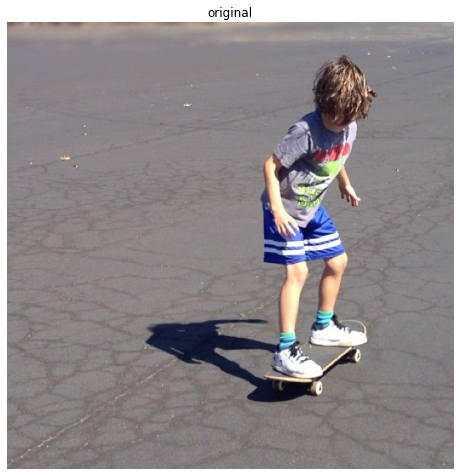

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


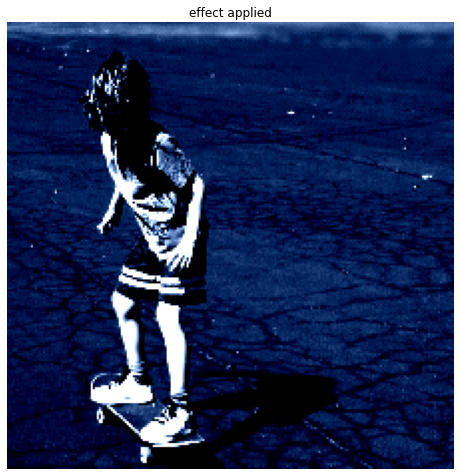

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


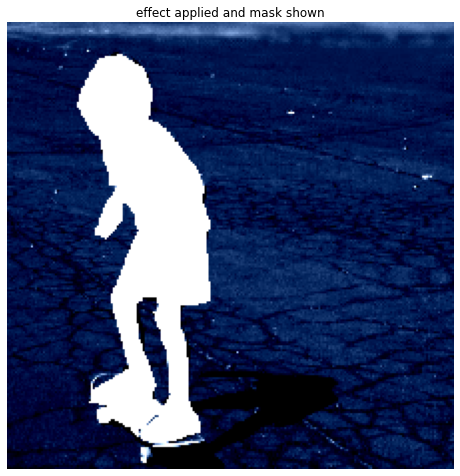

In [251]:
m = apply(newimg, c2, showtf=True)

#m2 = apply(original,t7)
#[dict(zip(*np.unique(np.array((i(m[:,:,:3])).nonzero()).T[:,2], return_counts=True))) for i in [lambda x: x >= 0, lambda x: x < 0]]


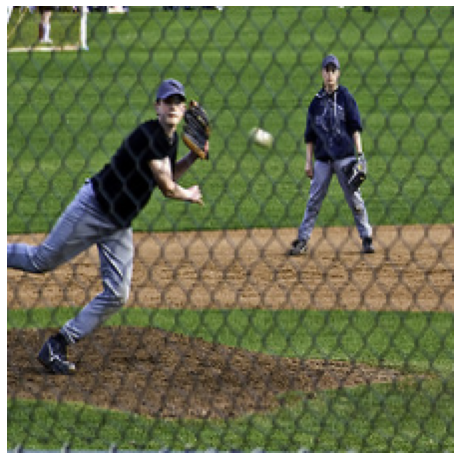

In [297]:
x = np.array(m,dtype=np.uint8)
show(x)



#mask = x[:, :, 3]
#pic = x[:, :, 1:]
#print(pic)
#I = Image.fromarray(x[:,:,:3])


{'license': 3, 'file_name': 'COCO_val2014_000000153344.jpg', 'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000153344.jpg', 'height': 428, 'width': 640, 'date_captured': '2013-11-22 20:59:12', 'flickr_url': 'http://farm3.staticflickr.com/2407/2477059973_870efb557b_z.jpg', 'id': 153344}


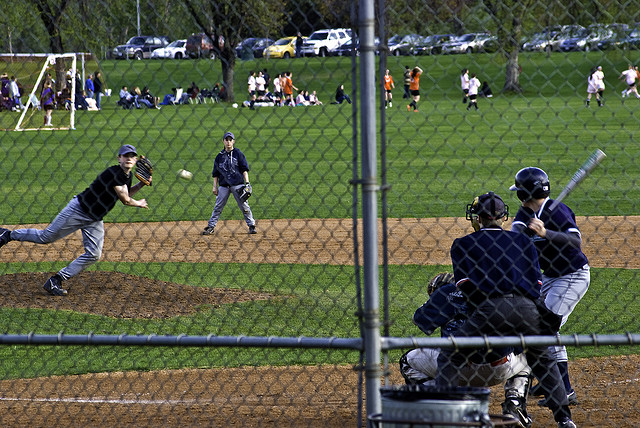

In [103]:

p2d = '../cocoapi/PythonAPI/data/train'
p2j = '../cocoapi/PythonAPI/data/annotations/instances_train2014.json'
# coco_train = datasets.CocoDetection(root = p2d,
#                                 annFile = p2j)
coco = COCO(p2j)


cats = coco2.loadCats(coco2.getCatIds())
catIds = coco2.getCatIds(catNms=['skateboard']);
# imgIds = coco.getImgIds(catIds=catIds );
imgIds2 = coco2.getImgIds(imgIds = [153344])
#img = coco2.loadImgs(imgIds2[np.random.randint(0,len(imgIds2))])[0]
img = coco2.loadImgs(imgIds2[0])[0]
print(img)
path = os.path.join(val,img['file_name'])
I = Image.open(path)
display(I)

# I = io.imread('../cocoapi/PythonAPI/data/train/COCO_train2014_000000000064.jpg')
# plt.axis('off')
# plt.imshow(I)
# plt.show()

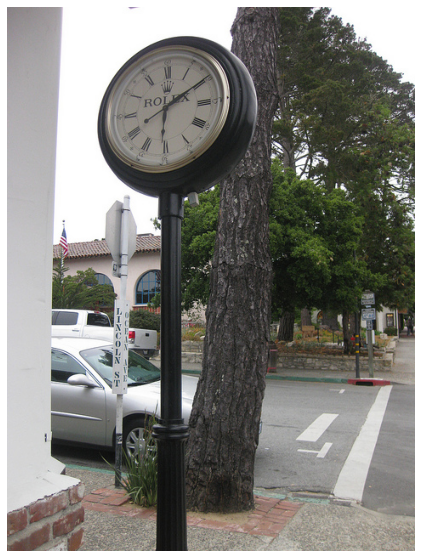

In [138]:
I = io.imread('../cocoapi/PythonAPI/data/train/COCO_train2014_000000000064.jpg')
plt.axis('off')
plt.imshow(I)
plt.show()


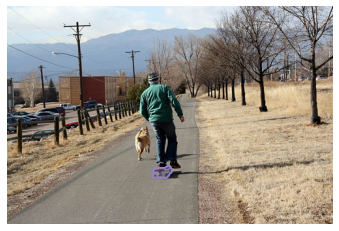

In [13]:
plt.imshow(I); plt.axis('off')
annIds = coco2.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco2.loadAnns(annIds)
coco2.showAnns(anns)

In [48]:
list(coco2.loadAnns(coco2.getAnnIds(imgIds=img['id']))[0].keys())

['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id']

In [119]:
ids = [x['segmentation'] for x in coco2.loadAnns(coco2.getAnnIds(imgIds=img['id']))]

In [120]:
print(ids[0])

[[189.35, 180.43, 192.05, 178.13, 193.4, 175.52, 192.29, 173.37, 189.75, 172.03, 187.45, 171.07, 185.79, 170.52, 184.12, 169.96, 182.06, 172.1, 180.55, 174.01, 179.92, 175.75, 179.6, 177.02, 182.37, 178.45, 189.04, 181.07, 189.75, 180.2, 189.75, 180.2]]


In [34]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

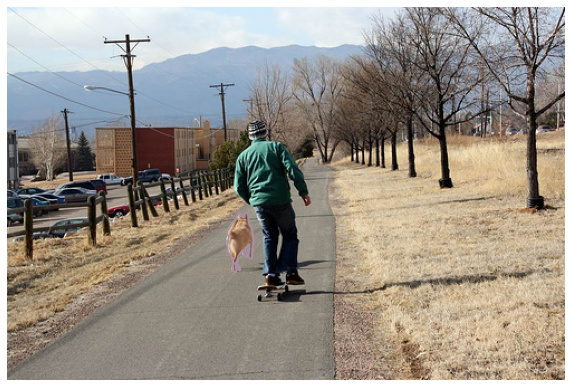

In [58]:
plt.figure(figsize=(10,10))
plt.imshow(I)
plt.axis('off')
ax = plt.gca()
poly = np.array(ids[0][0]).reshape((int(len(ids[0][0])/2), 2))
P = Polygon(poly)
c1 = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
p = PatchCollection([P], facecolor = c1, linewidths=0, alpha=0.4)
ax.add_collection(p)
c2 = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
p = PatchCollection([P], facecolor='none', edgecolors=c2, linewidths=2)
ax.add_collection(p)

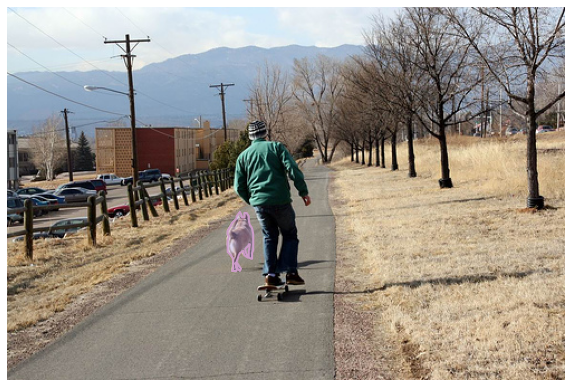

In [75]:
poly = np.array(ids[0][0]).reshape((int(len(ids[0][0])/2), 2))
P = Polygon(poly)
P.set_xy(np.round_(P.get_xy()))

fig = plt.figure(figsize=(10,10))
plt.imshow(I)
plt.axis('off')
ax = plt.gca()

c1 = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
p = PatchCollection([P], facecolor = c1, linewidths=0, alpha=0.4)
ax.add_collection(p)
c2 = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
p = PatchCollection([P], facecolor='none', edgecolors=c2, linewidths=2)
ax.add_collection(p)
img_buf = io2.BytesIO()
plt.savefig(img_buf, format='jpg')
img2 = Image.open(img_buf)

In [25]:
{x['name'] for x in coco2.loadCats(ids)}

TypeError: unhashable type: 'dict_keys'

In [76]:
x = [t(img2) for i in range(15)]

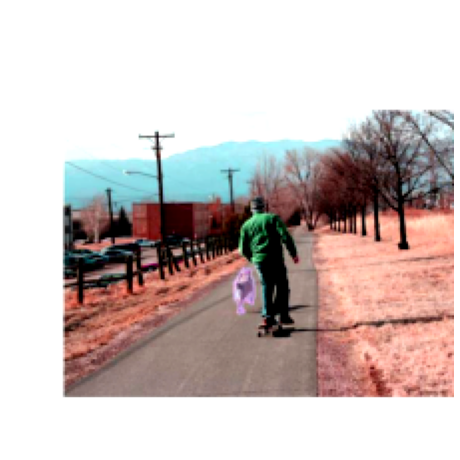

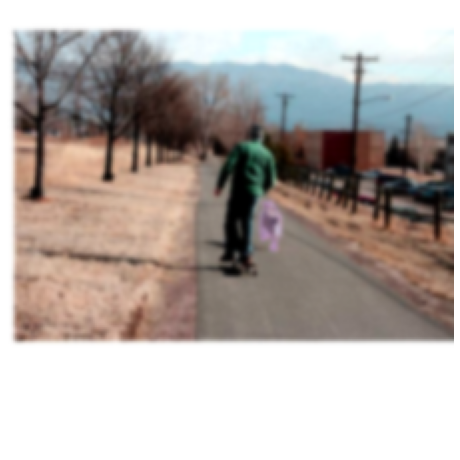

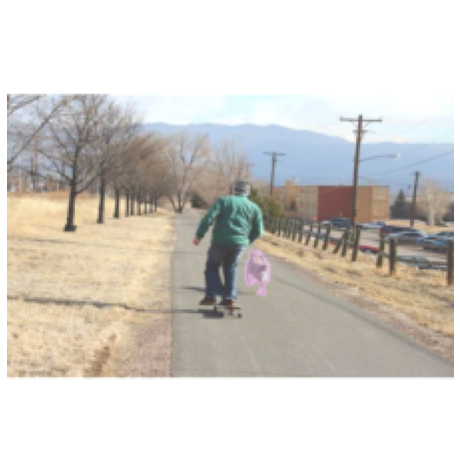

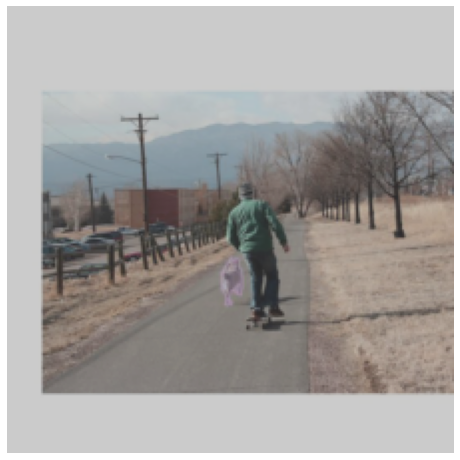

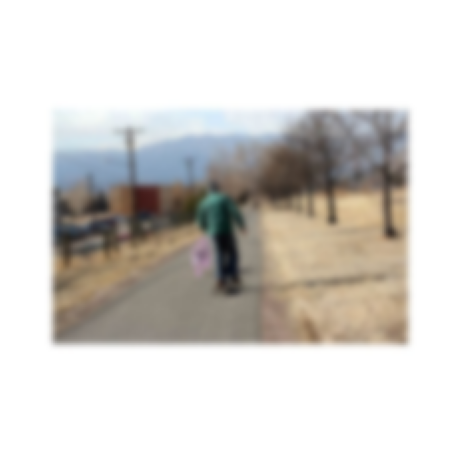

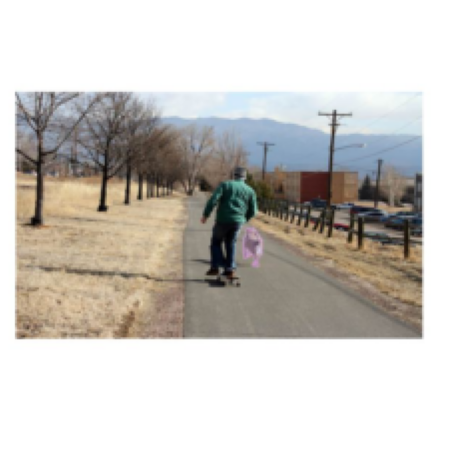

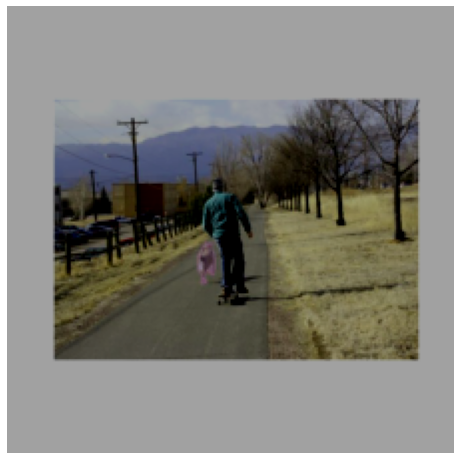

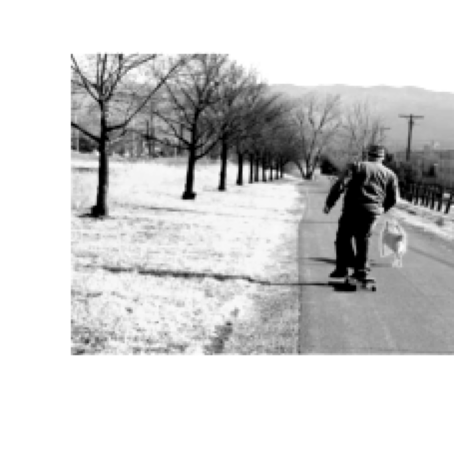

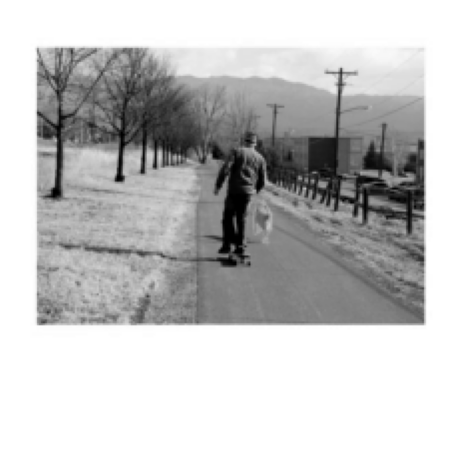

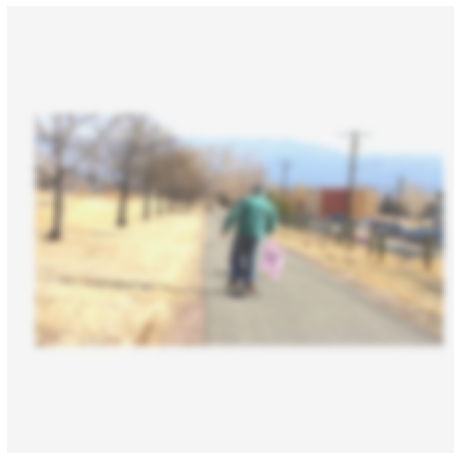

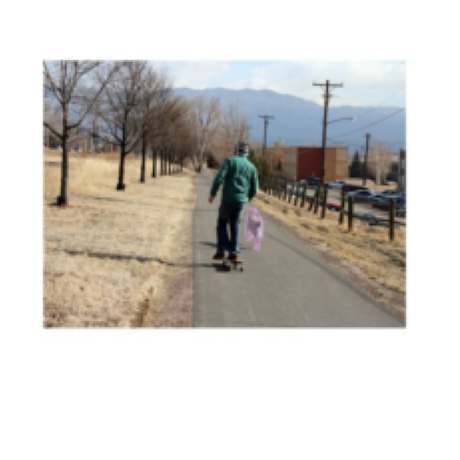

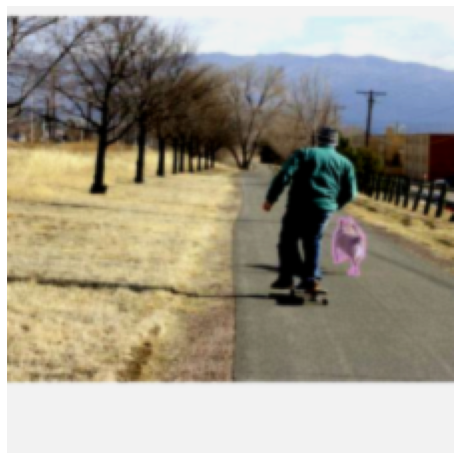

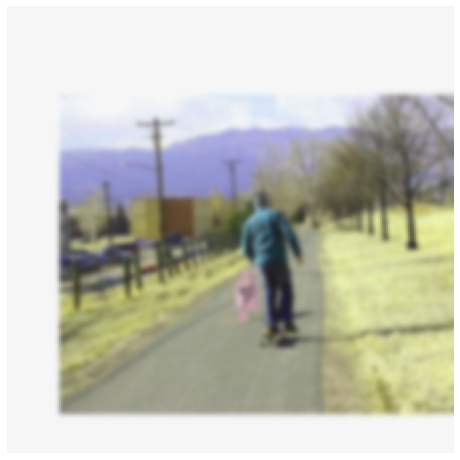

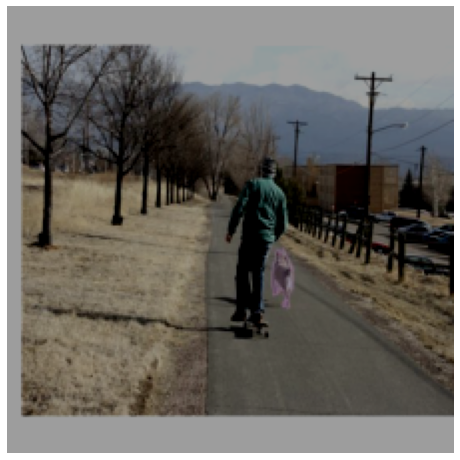

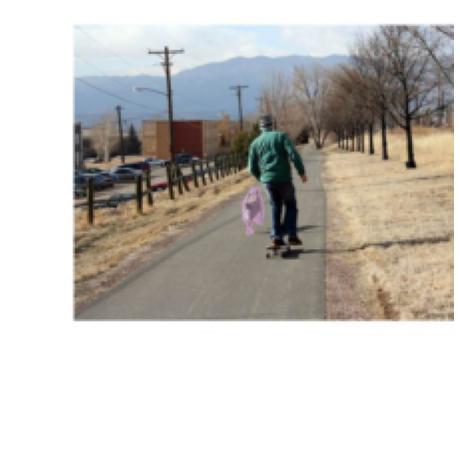

In [77]:
for i in x:
    plt.figure()
    plt.axis('off')
    plt.imshow(i)